# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install phik -q
!pip install lightgbm -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report
from datetime import datetime

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error, make_scorer

# импортируем класс RandomizedSearchCV и GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

## Загрузка данных и первичный анализ

In [3]:
df_path = 'https://code.s3.yandex.net/datasets/autos.csv'

In [4]:
try:
    df = pd.read_csv(df_path)
except:
    print('Проверьте путь к датасету')

In [5]:
def primary_information(df):
    """Вывод общей информации о датасете"""
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [6]:
def pass_value_barh(df):
    """Вывод графика с количеством пропущенных значений"""
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Процент пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('Пропусков нет')

Выведем общую информацию о датасете

In [7]:
primary_information(df)

Размерность: (354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведем даты к типу datetime

In [8]:
df['DateCrawled'] = pd.to_datetime(
    df['DateCrawled'], format="%Y-%m-%d"
)
df['DateCreated'] = pd.to_datetime(
    df['DateCreated'], format="%Y-%m-%d"
)
df['LastSeen'] = pd.to_datetime(
    df['LastSeen'], format="%Y-%m-%d"
)

Проверим датасет наналичие пропущенных значений

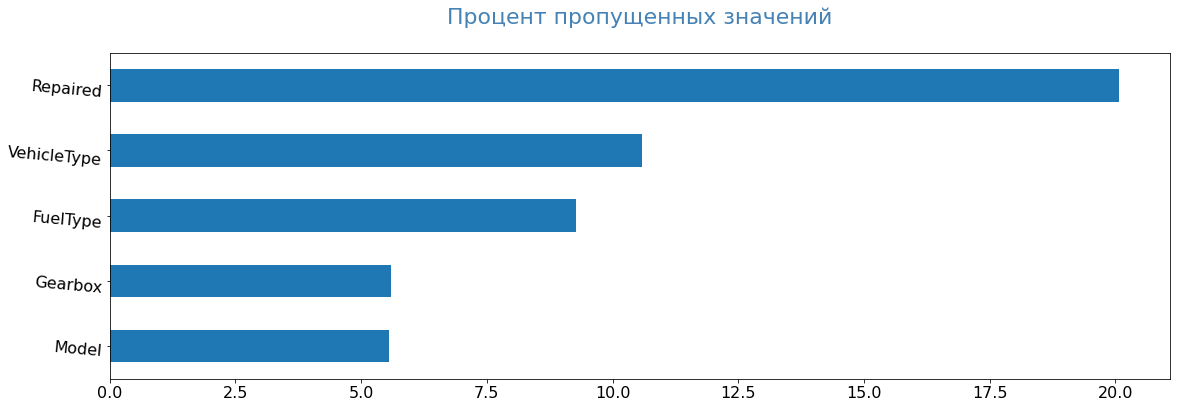

In [9]:
pass_value_barh(df)

Проверим датасет на наличие дубликатов

In [10]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Посмотрим количество уникальных значений в каждом поле

In [11]:
df.nunique().sort_values(ascending=False)

DateCrawled          271174
LastSeen             179150
PostalCode             8143
Price                  3731
Power                   712
Model                   250
RegistrationYear        151
DateCreated             109
Brand                    40
Kilometer                13
RegistrationMonth        13
VehicleType               8
FuelType                  7
Gearbox                   2
Repaired                  2
NumberOfPictures          1
dtype: int64

### Промежуточный вывод
Был успешно выгружен датасет, содержащий более 350'000 строк и 16 признаков:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро)

Первичный анализ показал, что датасет:
- имеет пропущенные значения в следующих полях:
    - `VehicleType`
    - `Gearbox`
    - `Model`
    - `FuelType`
    - `Repaired`
- содержит 4 полных дубликата
- содержит неинформативный признак `NumberOfPictures` с единственным уникальным значением

## Предобработка данных

Объявим функции, необходимые для анализа:

In [12]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

In [13]:
def draw_hists(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        df[cols[i]].hist(ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

In [14]:
def draw_barh(df, col, title):
    (
        df[col]
        .value_counts(ascending=True)
        .plot(kind = 'barh', figsize = (20,10), legend = False, fontsize = 16)
        .set_title('Распределение по брендам' + "\n", fontsize = 22, color = 'SteelBlue')
    )

In [15]:
def get_top_df(df, col, qty, include_others):
    df1 = df[col].value_counts(ascending=True).to_frame()
    df2 = df1[-qty:].copy()
    if include_others & (len(df1) > qty):
        df2.loc['others'] = [df1[col][:-qty].sum()]    
    return df2

In [16]:
def show_pie(df, columns, column_titles, main_title):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), sharey=True, figsize=(18, 6))
    if len(columns) == 1:
        (
            df[columns[0]].value_counts().plot.pie(autopct='%1.f%%', legend=False,
                wedgeprops = {"edgecolor" : "white", 
                              'linewidth': 2, 
                              'antialiased': True})
        )
        axes.title.set_text(column_titles[0])
    else:
        idx = 0
        for column in columns:    
            (
                df[column].value_counts().plot.pie(ax=axes[idx], autopct='%1.f%%', legend=False,
                    wedgeprops = {"edgecolor" : "white", 
                                  'linewidth': 2, 
                                  'antialiased': True})
            )
            axes[idx].title.set_text(column_titles[idx])
            idx+=1
    fig.suptitle(main_title, fontsize=30)

Разделим признаки на количественные и категориальные:

In [17]:
num_columns = ['Power', 'Kilometer', 'RegistrationYear', 'RegistrationMonth']
cat_columns = ['Model', 'PostalCode', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']
target = ['Price']

Удалим дубликаты

In [18]:
df.drop_duplicates(ignore_index=True, inplace=True)

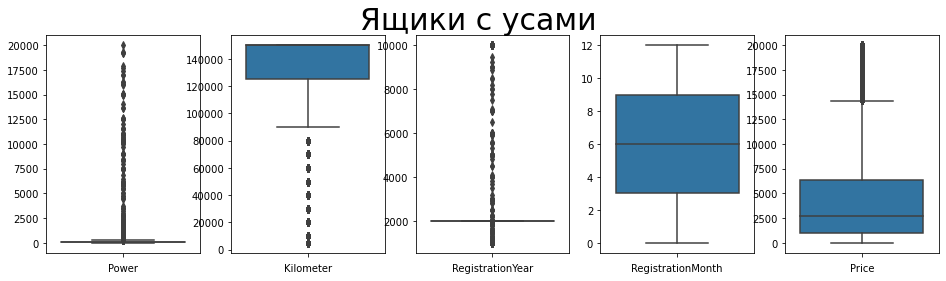

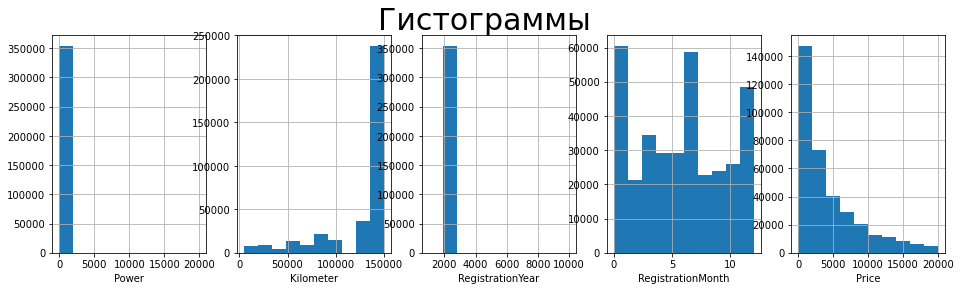

In [19]:
draw_boxplots(
    df, 
    num_columns + target, 
    "Ящики с усами"
)
draw_hists(
    df, 
    num_columns + target, 
    "Гистограммы"
)

На изображнных диаграммах видны аномальные значения:
- `Price` — присутствуют объявления с подозрительно низкой ценой, вплоть до 0
- `RegistrationYear` — год регистрации автомобиля превышает текущий год
- `Power` — мощность, указанная в некоторых анкетах, выходит за рамки разумных значений
- `RegistrationMonth` — диапазон в поле месяца регистрации автомобиля содержит 13 значений

Устраним найденные аномалии:

In [20]:
df.drop(df[(df['Price'] < 50)].index, inplace = True)
df.drop(df[(df['RegistrationYear'] > df['DateCrawled'].dt.year) | (df['RegistrationYear'] < 1950)].index, inplace = True)
df.drop(df[(df['Power'] > 500)].index, inplace = True)
df.loc[(df['RegistrationMonth'] == 0), 'RegistrationMonth'] = 1

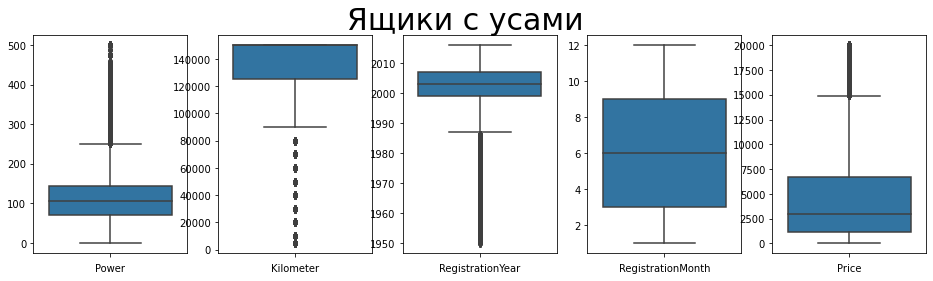

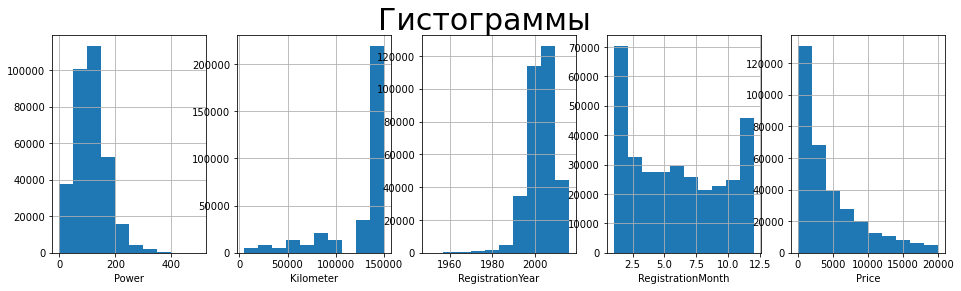

In [21]:
draw_boxplots(
    df, 
    num_columns + target, 
    "Ящики с усами"
)
draw_hists(
    df, 
    num_columns + target, 
    "Гистограммы"
)

Перейдем к категориальным переменным

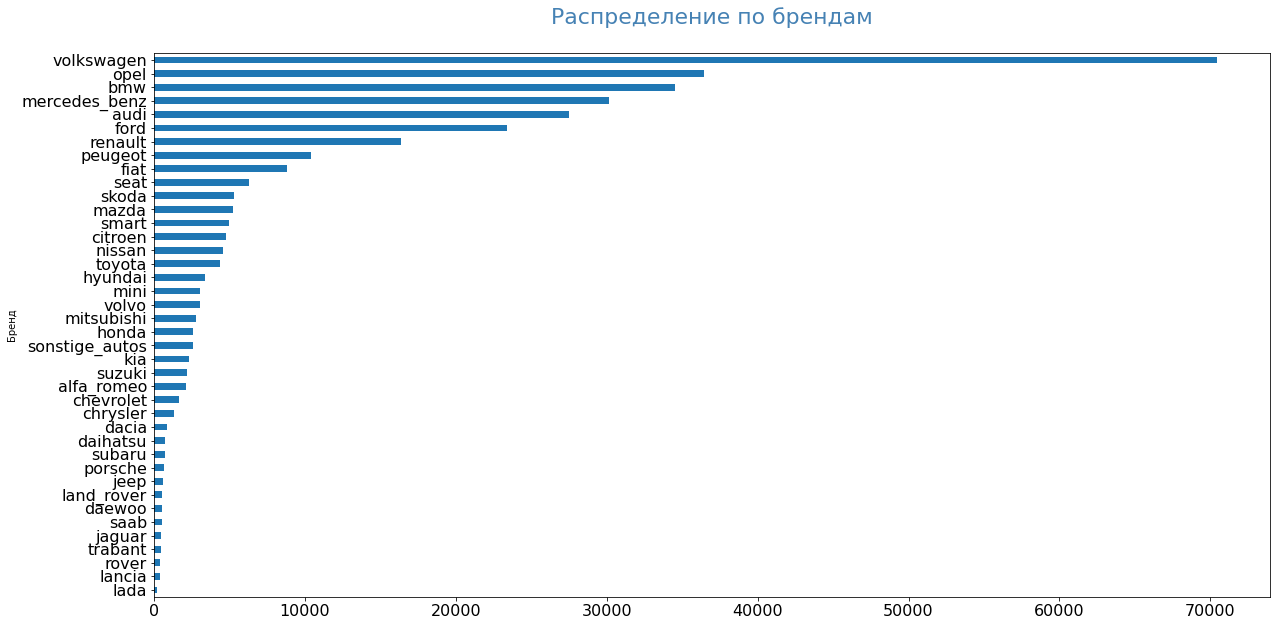

In [22]:
(
get_top_df(df, 'Brand', 40, False)
    .plot(kind = 'barh', figsize = (20,10), legend = False, fontsize = 16, xlabel='Бренд')
    .set_title('Распределение по брендам' + "\n", fontsize = 22, color = 'SteelBlue')
);

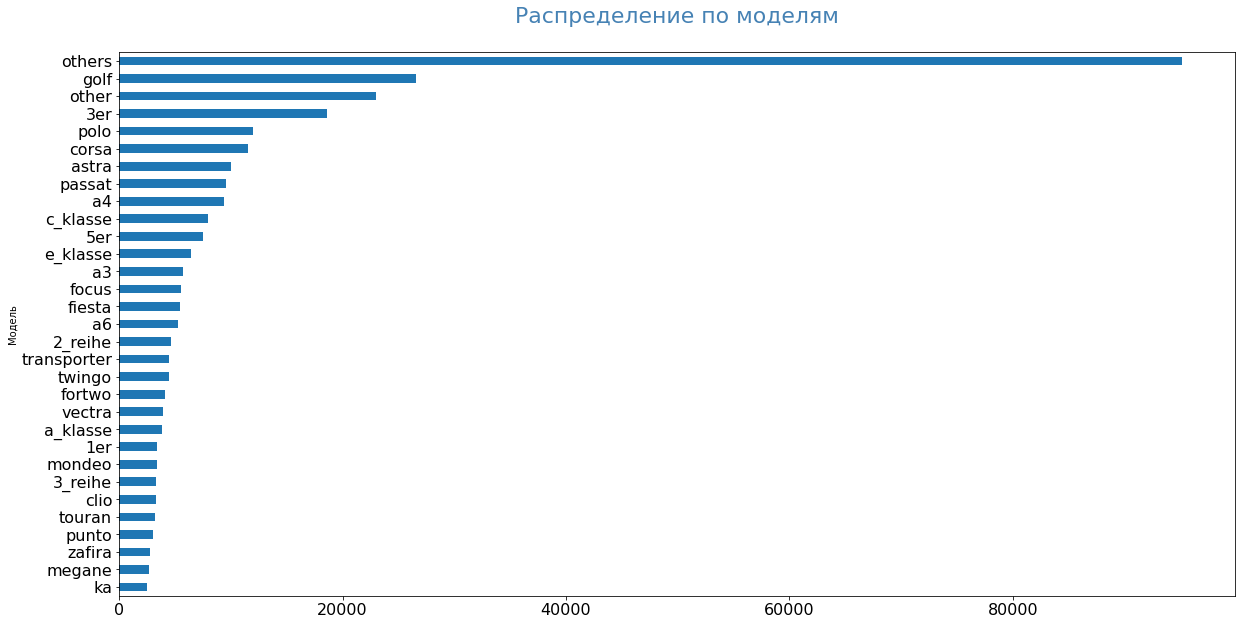

In [23]:
(
get_top_df(df, 'Model', 30, True)
    .plot(kind = 'barh', figsize = (20,10), legend = False, fontsize = 16, xlabel='Модель')
    .set_title('Распределение по моделям' + "\n", fontsize = 22, color = 'SteelBlue')
);

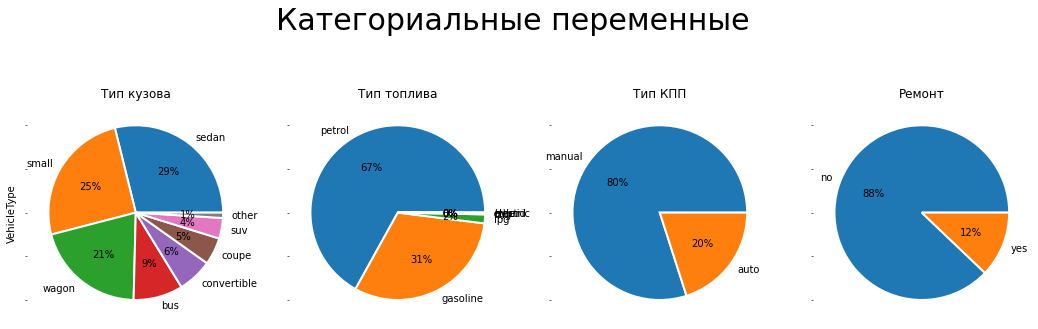

In [24]:
show_pie(df, 
         ['VehicleType', 'FuelType', 'Gearbox', 'Repaired'], 
         ['Тип кузова', 'Тип топлива', 'Тип КПП', 'Ремонт'], 
         "Категориальные переменные")

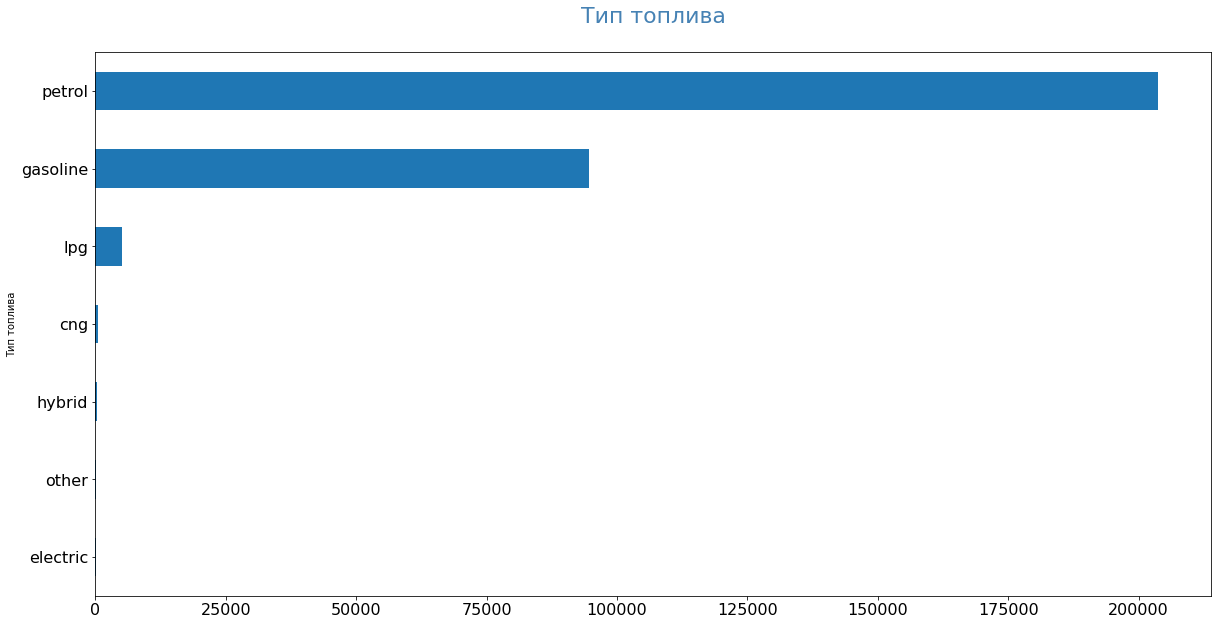

In [25]:
(
get_top_df(df, 'FuelType', 0, False)
    .plot(kind = 'barh', figsize = (20,10), legend = False, fontsize = 16, xlabel='Тип топлива')
    .set_title('Тип топлива' + "\n", fontsize = 22, color = 'SteelBlue')
);

Заполним пропуски в данных следующим образом:
- в полях `VehicleType`, `Model`, `FuelType` пропуски объединим с категорией `other`
- в полях `Gearbox` и `Repaired` для пропусков создадим категорию `unknown`

In [26]:
df['VehicleType'].fillna(value='other', inplace=True)
df['Model'].fillna(value='other', inplace=True)
df['FuelType'].fillna(value='other', inplace=True)
df['Gearbox'].fillna(value='unknown', inplace=True)
df['Repaired'].fillna(value='unknown', inplace=True)

Создадим синтетический признак `CarAge` - возраст машины

In [27]:
df['CarAge'] = df['DateCrawled'].dt.year - df['RegistrationYear']

Определим информативные признаки:

In [28]:
num_columns = ['Power', 'Kilometer', 'CarAge']
cat_columns = ['Model', 'PostalCode', 'Brand', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired']
target = ['Price']

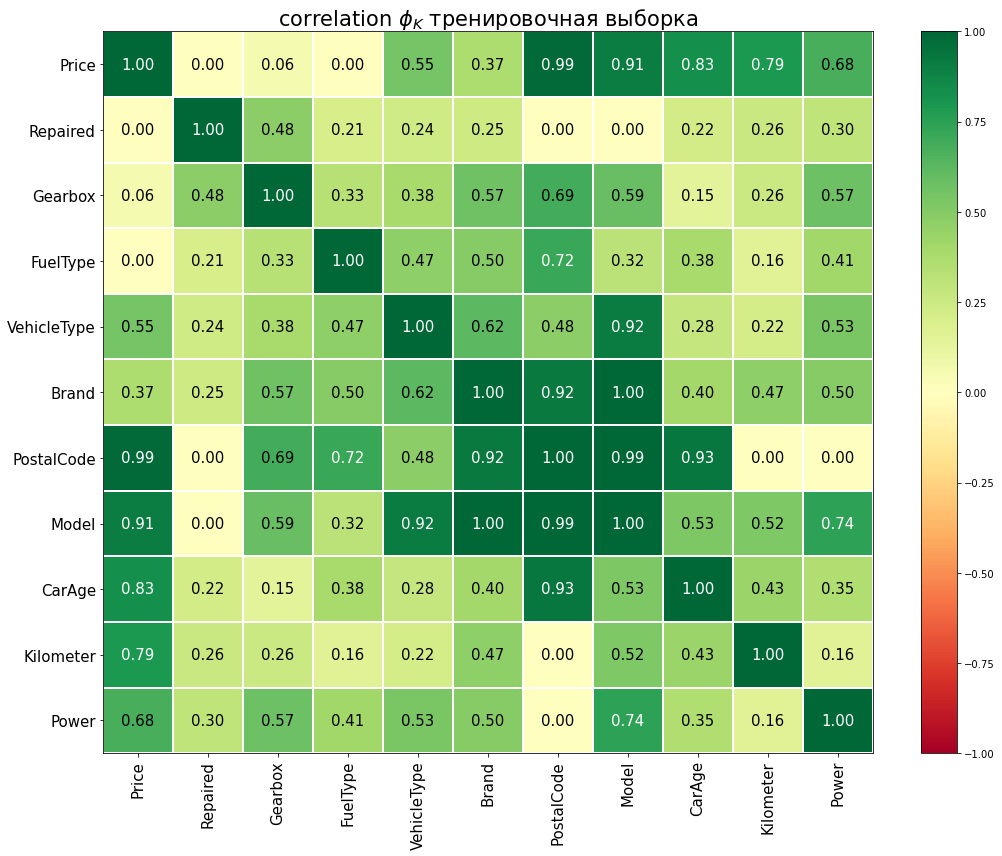

In [29]:
phik_overview = df[num_columns + cat_columns + target].sample(1000).phik_matrix(
    interval_cols=num_columns
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

## Обучение моделей

Зафиксируем константы

In [30]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Создадим метрику RMSE

In [31]:
def rmse_score(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print('RMSE: %2.2f' % rmse)
    return rmse

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

In [32]:
X = df[num_columns + cat_columns]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((245772, 10), (81924, 10), (245772, 1), (81924, 1))

In [33]:
cat_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('cat',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [34]:
data_preprocessor = ColumnTransformer(
    [('cat', cat_pipe, cat_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [35]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [36]:
tree_param_grid = [
    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor()],
        'models__max_depth': [7, 10],
        'models__min_samples_split': [2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [37]:
forest_param_grid = [
    # словарь для модели RandomForestRegressor() 
    {
        'models': [RandomForestRegressor()],
        'preprocessor__num': [StandardScaler()]
    }
]

In [38]:
lgbm_param_grid = [
    # словарь для модели LGBMRegressor()
    {
        'models': [lgb.LGBMRegressor()],
        'models__num_leaves': [31, 47],
        'models__n_estimators': [100, 200],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [39]:
%%time
tree_grid = GridSearchCV(
    pipe_final, 
    tree_param_grid,
    scoring=rmse_scorer,
    n_jobs=None
)
tree_grid.fit(X_train, y_train.values.ravel())

print('Лучшая модель DecisionTreeRegressor и её параметры:\n\n', tree_grid.best_estimator_)

RMSE: 2223.51
RMSE: 2183.42
RMSE: 2202.68
RMSE: 2191.67
RMSE: 2207.60
RMSE: 2223.51
RMSE: 2183.42
RMSE: 2202.68
RMSE: 2191.67
RMSE: 2207.72
RMSE: 2223.51
RMSE: 2183.42
RMSE: 2202.68
RMSE: 2191.67
RMSE: 2207.60
RMSE: 2223.51
RMSE: 2183.42
RMSE: 2202.68
RMSE: 2191.67
RMSE: 2207.72
RMSE: 2026.49
RMSE: 1991.44
RMSE: 1998.33
RMSE: 1990.39
RMSE: 2010.57
RMSE: 2024.92
RMSE: 1992.14
RMSE: 2000.38
RMSE: 1988.36
RMSE: 2010.92
RMSE: 2025.02
RMSE: 1987.34
RMSE: 1998.27
RMSE: 1986.90
RMSE: 2007.94
RMSE: 2022.96
RMSE: 1986.35
RMSE: 1997.91
RMSE: 1988.01
RMSE: 2010.49
Лучшая модель DecisionTreeRegressor и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                

In [40]:
%%time
forest_grid = GridSearchCV(
    pipe_final, 
    forest_param_grid,
    scoring=rmse_scorer,
    n_jobs=None
)
forest_grid.fit(X_train, y_train.values.ravel())

print('Лучшая модель RandomForestRegressor и её параметры:\n\n', forest_grid.best_estimator_)

RMSE: 1636.01
RMSE: 1615.79


KeyboardInterrupt: 

In [ ]:
%%time
lgbm_grid = GridSearchCV(
    pipe_final, 
    lgbm_param_grid,
    scoring=rmse_scorer,
    n_jobs=None
)
lgbm_grid.fit(X_train, y_train.values.ravel())

print('Лучшая модель LGBMRegressor и её параметры:\n\n', lgbm_grid.best_estimator_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 196617, number of used features: 10
[LightGBM] [Info] Start training from score 4618.778336
RMSE: 1723.03
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 196617, number of used features: 10
[LightGBM] [Info] Start training from score 4632.943423
RMSE: 1695.51
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006510 seconds.
You can set `force_row_wise=true` to remove the ov

## Анализ моделей

In [ ]:
y_test_pred = tree_grid.predict(X_test)
tree_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Метрика RMSE на тестовой выборке лечшей модели DecisionTreeRegressor: {tree_rmse:2f}")

In [ ]:
y_test_pred = forest_grid.predict(X_test)
forest_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Метрика RMSE на тестовой выборке лечшей модели RandomForestRegressor: {forest_rmse:2f}")

In [ ]:
y_test_pred = lgbm_grid.predict(X_test)
lgbm_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Метрика RMSE на тестовой выборке лечшей модели LGBMRegressor: {lgbm_rmse:2f}")

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей